# 使用卷积神经网络进行图像分类

**作者:** [PaddlePaddle](https://github.com/PaddlePaddle) <br>
**日期:** 2022.5 <br>
**摘要:** 本示例教程将会演示如何使用飞桨的卷积神经网络来完成图像分类任务。这是一个较为简单的示例，将会使用一个由三个卷积层组成的网络完成[cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)数据集的图像分类任务。

## 一、环境配置

本教程基于PaddlePaddle 2.3.0 编写，如果你的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) PaddlePaddle 2.3.0 。

In [2]:
import paddle
import paddle.nn.functional as F
from paddle.vision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

print(paddle.__version__)

2.3.0


## 二、加载数据集

本案例将会使用飞桨提供的API完成数据集的下载并为后续的训练任务准备好数据迭代器。cifar10数据集由60000张大小为32 * 32的彩色图片组成，其中有50000张图片组成了训练集，另外10000张图片组成了测试集。这些图片分为10个类别，将训练一个模型能够把图片进行正确的分类。

In [ ]:
transform = ToTensor()
cifar10_train = paddle.vision.datasets.Cifar10(mode='train',
                                               transform=transform)
cifar10_test = paddle.vision.datasets.Cifar10(mode='test',
                                              transform=transform)

## 三、组建网络
接下来使用飞桨定义一个使用了三个二维卷积（ ``Conv2D`` ) 且每次卷积之后使用 ``relu`` 激活函数，两个二维池化层（ ``MaxPool2D`` ），和两个线性变换层组成的分类网络，来把一个(32, 32, 3)形状的图片通过卷积神经网络映射为10个输出，这对应着10个分类的类别。

In [ ]:
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super().__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## 四、模型训练&预测

接下来，用一个循环来进行模型的训练，将会: <br> 
- 使用 ``paddle.optimizer.Adam`` 优化器来进行优化。 
- 使用 ``F.cross_entropy`` 来计算损失值。 
- 使用 ``paddle.io.DataLoader`` 来加载数据并组建batch。

In [ ]:
epoch_num = 10
batch_size = 32
learning_rate = 0.001

In [ ]:
val_acc_history = []
val_loss_history = []

def train(model):
    print('start training ... ')
    # turn into training mode
    model.train()

    opt = paddle.optimizer.Adam(learning_rate=learning_rate,
                                parameters=model.parameters())

    train_loader = paddle.io.DataLoader(cifar10_train,
                                        shuffle=True,
                                        batch_size=batch_size)

    valid_loader = paddle.io.DataLoader(cifar10_test, batch_size=batch_size)
    
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)

            if batch_id % 1000 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[validation] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        val_acc_history.append(avg_acc)
        val_loss_history.append(avg_loss)
        model.train()

model = MyNet(num_classes=10)
train(model)

W0509 15:07:12.933425   213 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0509 15:07:12.937302   213 device_context.cc:465] device: 0, cuDNN Version: 7.6.


start training ... 
epoch: 0, batch_id: 0, loss is: [2.658352]
epoch: 0, batch_id: 1000, loss is: [1.4308808]
[validation] accuracy/loss: 0.5611022114753723/1.2377959489822388
epoch: 1, batch_id: 0, loss is: [1.1941562]
epoch: 1, batch_id: 1000, loss is: [1.3470001]
[validation] accuracy/loss: 0.626697301864624/1.0527281761169434
epoch: 2, batch_id: 0, loss is: [1.045943]
epoch: 2, batch_id: 1000, loss is: [0.9645134]
[validation] accuracy/loss: 0.6651358008384705/0.9612839221954346
epoch: 3, batch_id: 0, loss is: [0.68462646]
epoch: 3, batch_id: 1000, loss is: [1.0284429]
[validation] accuracy/loss: 0.6602436304092407/0.9790637493133545
epoch: 4, batch_id: 0, loss is: [1.0286212]
epoch: 4, batch_id: 1000, loss is: [0.9716246]
[validation] accuracy/loss: 0.6880990266799927/0.897951066493988
epoch: 5, batch_id: 0, loss is: [0.8987363]
epoch: 5, batch_id: 1000, loss is: [0.78846645]
[validation] accuracy/loss: 0.7095646858215332/0.8490572571754456
epoch: 6, batch_id: 0, loss is: [0.64002

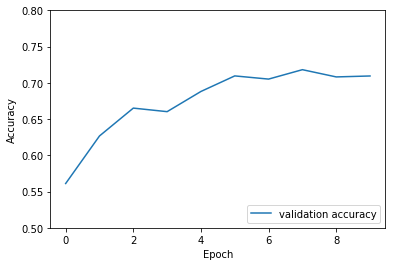

In [ ]:
plt.plot(val_acc_history, label = 'validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.8])
plt.legend(loc='lower right')

## The End
从上面的示例可以看到，在cifar10数据集上，使用简单的卷积神经网络，用飞桨可以达到70%以上的准确率。你也可以通过调整网络结构和参数，达到更好的效果。